## Introduction

This coursework aims to implement the universal workflow from Francois Chollet's Deep Learning with Python and apply it to classify mushrooms as either edible or not edible.

We are using the [Mushroom Dataset](https://archive.ics.uci.edu/ml/datasets/mushroom) from UCI’s Machine Learning Repository to implement our model.

The overall workflow will reflect the literature:

1. Define the problem and assemble a dataset
2. Choose a measure of success
2. Decide on an evaluation protocol
2. Prepare the data
2. Develop a model that does better than a baseline
2. Develop a model that overfits
2. Regularize the model and tune its hyperparameters

# Define the problem and assemble a dataset

Our hypothetical problem is the classification of mushrooms as edible or non-edible, with the purpose of selecting mushrooms for use in human food production. Since mushrooms can be poisonous, the goal is to prevent humans from getting sick by eating poisonous mushrooms.

Let's frame the problem in more detail. Our input data is the aforementioned dataset, which is a multivariate set of data about mushrooms and 22 features about the sample mushrooms. Based on these features, we are trying to predict if the mushrooms are suitable for human consumption.

The task at hand is binary classification - we determine if a mushroom edible or not.

Using the data information file, we can load up a list of features for our data.

In [1]:
column_names = ['class',
                'cap-shape',
                'cap-surface',
                'cap-color',
                'bruises?',
                'odor',
                'gill-attachment',
                'gill-spacing',
                'gill-size',
                'gill-color',
                'stalk-shape',
                'stalk-root',
                'stalk-surface-above-ring',
                'stalk-surface-below-ring',
                'stalk-color-above-ring',
                'stalk-color-below-ring',
                'veil-type',
                'veil-color',
                'ring-number',
                'ring-type',
                'spore-print-color',
                'population',
                'habitat']

We can import our dataset using `pandas`.

In [2]:
import pandas as pd

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data'

mushrooms = pd.read_csv(url, header=None, names=column_names)

# Choose a measure of success

Since our problem involves the prevention of human sickness or death, we will use precision as a measure of success. Precision is the ability of the classifier not to label mushrooms which are poisonous as edible. This places a preference for correct predictions of poisonous mushrooms, as we prefer if edible mushrooms are misidentified as poisonous rather than poisonous mushrooms being misidentified as edible.

In [4]:
from sklearn.metrics import precision_score

# Decide on an evaluation protocol

I'll apply 10-fold cross validation to evaluate our model. While a simple holdout validation set might be enough, our dataset of 8.000 samples might not be enough.

In [14]:
from sklearn.model_selection import train_test_split, cross_validate

First lets split our data into a feature matrix (`X`), and a target vector (`y`). We will use [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) to encode our categorical variables.

In [33]:
import category_encoders as ce

#Drop target feature
X = mushrooms.drop(columns='class') #Encode categorical features
X = ce.OneHotEncoder(use_cat_names=True).fit_transform(X)
y = mushrooms['class'].replace({'p':0, 'e':1})

print('Feature matrix size:',X.shape)
print('Target vector size:',len(y))

Feature matrix size: (8124, 117)
Target vector size: 8124


In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.2, stratify=y)

print('Training feature matrix size:',X_train.shape)
print('Training target vector size:',y_train.shape)
print('Test feature matrix size:',X_test.shape)
print('Test target vector size:',y_test.shape)

Training feature matrix size: (6499, 117)
Training target vector size: (6499,)
Test feature matrix size: (1625, 117)
Test target vector size: (1625,)


In [35]:
print(mushrooms.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises?                  8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

In [36]:
print(mushrooms.isna().sum())

class                       0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises?                    0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64


In [37]:
import numpy as np
mushrooms = mushrooms.replace({'?':np.NaN})
print(mushrooms.isna().sum())

class                       0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises?                    0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64


In [38]:
mushrooms['stalk-root'] = mushrooms['stalk-root'].replace(np.NaN,'m')

print(mushrooms['stalk-root'].value_counts())

b    3776
m    2480
e    1120
c     556
r     192
Name: stalk-root, dtype: int64


In [39]:
mushrooms['class'].value_counts(normalize=True)

e    0.517971
p    0.482029
Name: class, dtype: float64

In [40]:
majority_class = y_train.mode()[0]

baseline_predictions = [majority_class] * len(y_train)

In [41]:
print(X_train)

      cap-shape_x  cap-shape_b  cap-shape_s  cap-shape_f  cap-shape_k  \
972             0            0            0            1            0   
6451            1            0            0            0            0   
3869            1            0            0            0            0   
3732            0            0            0            1            0   
482             0            0            0            1            0   
...           ...          ...          ...          ...          ...   
3275            0            0            0            1            0   
4913            1            0            0            0            0   
5338            0            0            0            1            0   
3933            1            0            0            0            0   
731             1            0            0            0            0   

      cap-shape_c  cap-surface_s  cap-surface_y  cap-surface_f  cap-surface_g  \
972             0              0          

In [42]:
from sklearn.metrics import accuracy_score

majority_class_accuracy = accuracy_score(baseline_predictions, y_train)
print(majority_class_accuracy)

0.5179258347438067


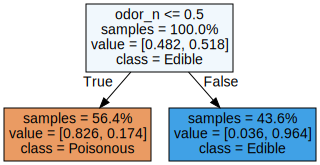

In [44]:
from sklearn.tree import DecisionTreeClassifier
import graphviz
from sklearn.tree import export_graphviz

tree = DecisionTreeClassifier(max_depth=1)

# Fit the model
tree.fit(X_train, y_train)# Visualize the tree
dot_data = export_graphviz(tree, out_file=None, feature_names=X_train.columns, class_names=['Poisonous', 'Edible'], filled=True, impurity=False, proportion=True)

graphviz.Source(dot_data)

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

def model_analysis(model, train_X, train_y):
	model_probabilities = model.predict_proba(train_X)
	
	Model_Prediction_Probability = []

	for _ in range(len(train_X)):
		x = max(model_probabilities[_])
		Model_Prediction_Probability.append(x)
		
	plt.figure(figsize=(15,10)) 
	
	sns.histplot(Model_Prediction_Probability)
	
	plt.title('Best Model Prediction Probabilities') 
	
	# Set x and y ticks
	plt.xticks(color='gray')
	plt.yticks(color='gray')  
	
	# Create axes object with plt. get current axes
	ax = plt.gca()
	
	# Set grid lines
	ax.grid(visible=True, which='major', axis='y', color='black', alpha=.2)
	
	# Set facecolor
	ax.set_facecolor('white')
	
	# Remove box
	ax.spines['top'].set_visible(False)
	ax.spines['right'].set_visible(False)
	ax.spines['bottom'].set_visible(False)
	ax.spines['left'].set_visible(False)
	ax.tick_params(color='white')
	
	plt.show();

	model_predictions = model.predict(train_X)
	
	# Classification Report
	print('\n\n', classification_report(train_y, model_predictions, target_names=['0-Poisonous', '1-Edible']))  
	
	# Confusion Matrix
	con_matrix = pd.DataFrame(confusion_matrix(train_y, model_predictions), columns=['Predicted Poison', 'Predicted Edible'], index=['Actual Poison', 'Actual Edible'])

	plt.figure(figsize=(15,10))
	sns.heatmap(data=con_matrix, cmap='cool'); 
	plt.title('Model Confusion Matrix')
	plt.show();

	return con_matrix

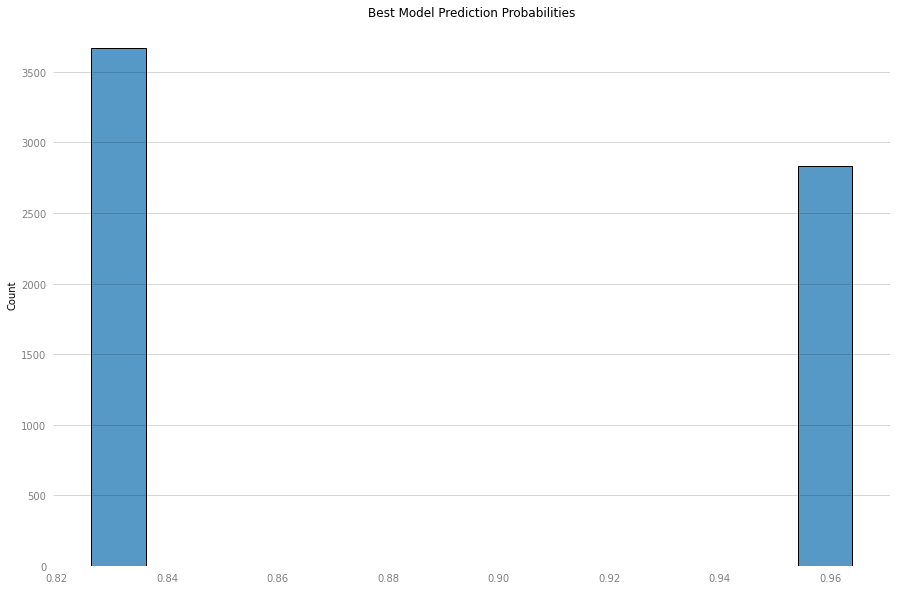



               precision    recall  f1-score   support

 0-Poisonous       0.83      0.97      0.89      3133
    1-Edible       0.96      0.81      0.88      3366

    accuracy                           0.89      6499
   macro avg       0.90      0.89      0.89      6499
weighted avg       0.90      0.89      0.89      6499



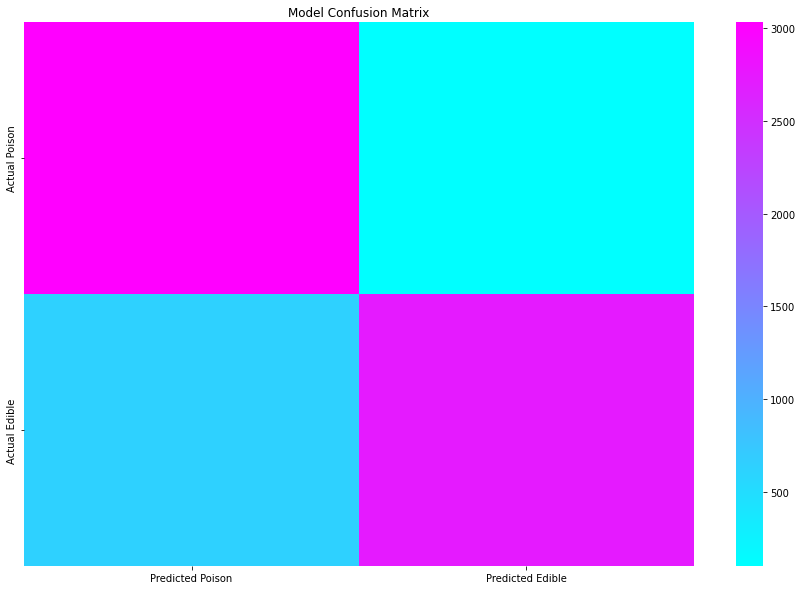

,Predicted Poison,Predicted Edible
Actual Poison,3031,102
Actual Edible,637,2729


In [56]:
model_analysis(tree, X_train, y_train)

In [57]:
tree_predictions = tree.predict(X_train)

accuracy_score(y_train, tree_predictions)

0.8862901984920757

In [58]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators=100, max_depth=5)

cv = cross_validate(estimator = random_forest, X = X_train, y = y_train, scoring='accuracy', n_jobs=-1, cv=10, verbose=10, return_train_score=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


[CV] START .....................................................................
[CV] START .....................................................................[CV] START .....................................................................

[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ..................., score=(train=0.991, test=0.985) total time=   0.2s
[CV] END ..................., score=(train=0.990, test=0.991) total time=   0.2s
[CV] END ...................

[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    1.0s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    1.0s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    1.0s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.0s finished


In [59]:
random_forest.fit(X_test, y_test)

test_predictions = random_forest.predict(X_train)

accuracy_score(y_train, test_predictions)

0.9906139406062471

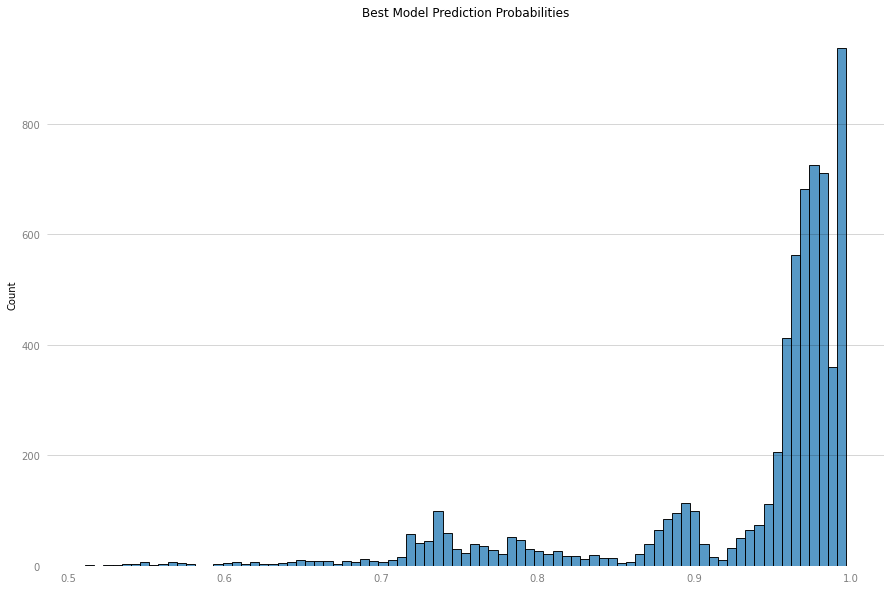



               precision    recall  f1-score   support

 0-Poisonous       1.00      0.98      0.99      3133
    1-Edible       0.98      1.00      0.99      3366

    accuracy                           0.99      6499
   macro avg       0.99      0.99      0.99      6499
weighted avg       0.99      0.99      0.99      6499



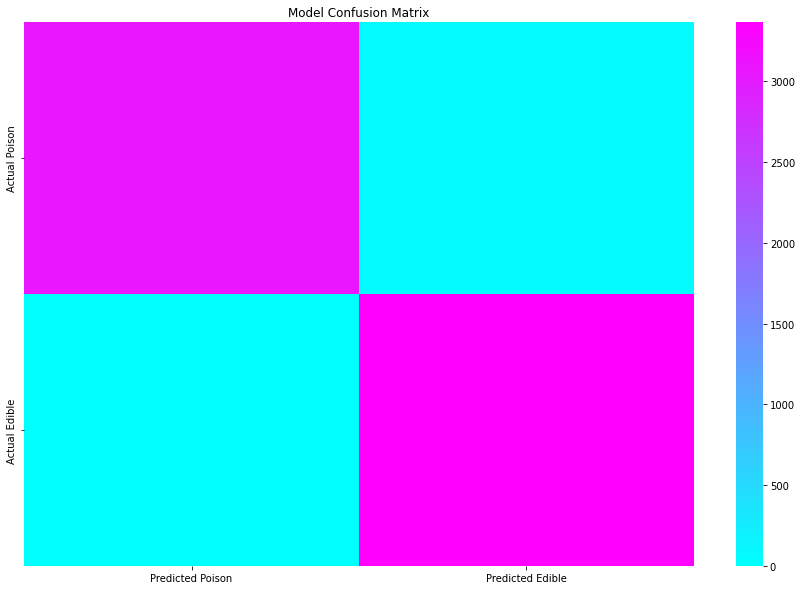

,Predicted Poison,Predicted Edible
Actual Poison,3072,61
Actual Edible,0,3366


In [60]:
model_analysis(random_forest, X_train, y_train)

In [61]:
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    'max_depth':[1, 2, 3, 4, 5],
    'n_estimators': [10, 25, 50, 100, 150, 200]}
	
search = RandomizedSearchCV(estimator = RandomForestClassifier(), param_distributions = param_distributions, n_iter=100, scoring='precision', n_jobs=-1, cv=10, verbose=10, return_train_score=True)

search.fit(X_train, y_train)

/opt/homebrew/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 30 is smaller than n_iter=100. Running 30 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 10 folds for each of 30 candidates, totalling 300 fits
[CV 2/10; 1/30] START max_depth=1, n_estimators=10..............................
[CV 1/10; 1/30] START max_depth=1, n_estimators=10..............................
[CV 3/10; 1/30] START max_depth=1, n_estimators=10..............................
[CV 5/10; 1/30] START max_depth=1, n_estimators=10..............................
[CV 4/10; 1/30] START max_depth=1, n_estimators=10..............................
[CV 6/10; 1/30] START max_depth=1, n_estimators=10..............................
[CV 5/10; 1/30] END max_depth=1, n_estimators=10;, score=(train=0.915, test=0.929) total time=   0.0s
[CV 4/10; 1/30] END max_depth=1, n_estimators=10;, score=(train=0.856, test=0.889) total time=   0.0s
[CV 1/10; 1/30] END max_depth=1, n_estimators=10;, score=(train=0.869, test=0.844) total time=   0.0s
[CV 3/10; 1/30] END max_depth=1, n_estimators=10;, score=(train=0.898, test=0.889) total time=   0.0s
[CV 2/10; 1/30] END max_depth=1, n_estimato

RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [1, 2, 3, 4, 5],
                                        'n_estimators': [10, 25, 50, 100, 150,
                                                         200]},
                   return_train_score=True, scoring='precision', verbose=10)

In [62]:
best_model = search.best_estimator_

best_model

RandomForestClassifier(max_depth=5, n_estimators=10)

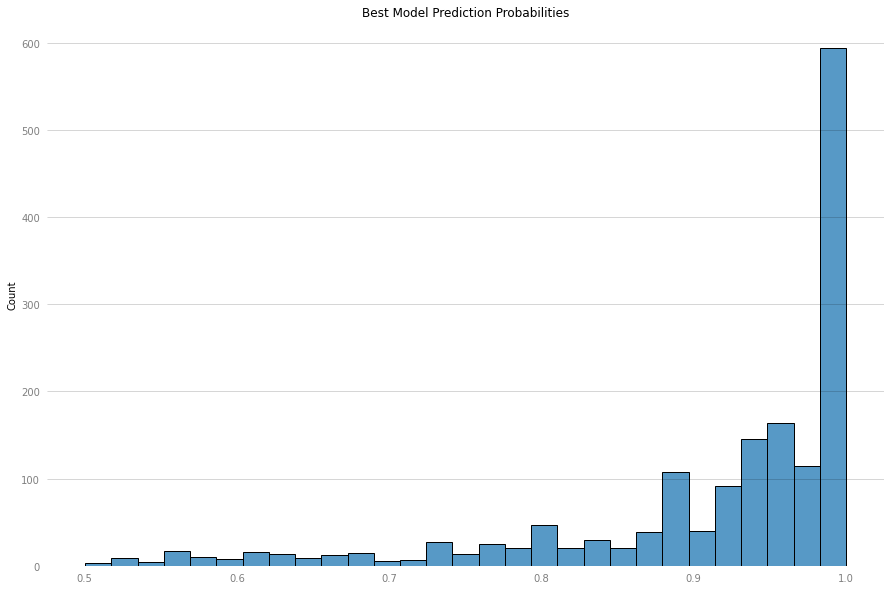



               precision    recall  f1-score   support

 0-Poisonous       1.00      0.99      0.99       783
    1-Edible       0.99      1.00      1.00       842

    accuracy                           1.00      1625
   macro avg       1.00      0.99      1.00      1625
weighted avg       1.00      1.00      1.00      1625



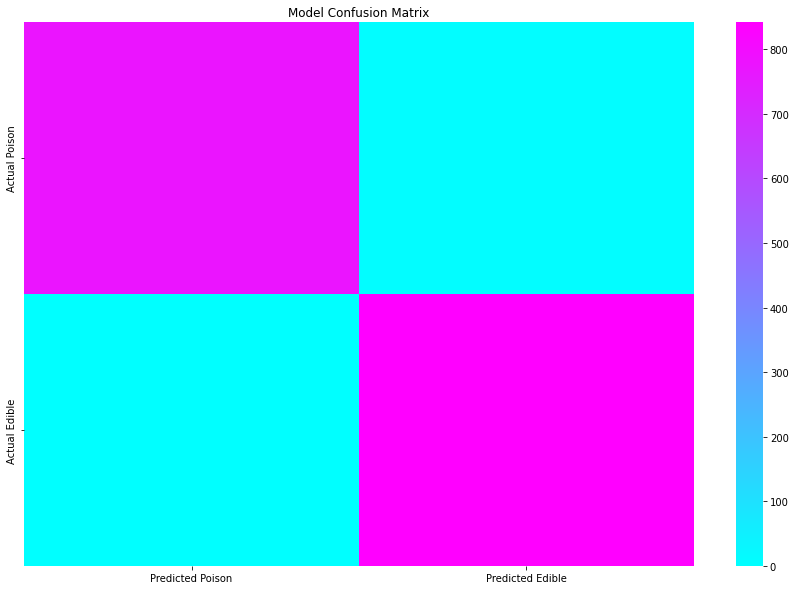

,Predicted Poison,Predicted Edible
Actual Poison,775,8
Actual Edible,0,842


In [63]:
model_analysis(best_model, X_test, y_test)